In [1]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics.Geodesy
using Flight.FlightPhysics.Kinematics
using Flight.FlightComponents.Aircraft
using Flight.FlightAircraft.C172FBW

using ControlSystems
using RobustAndOptimalControl

In [21]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics
ac.physics.airframe.pld.u.m_pilot = 75
ac.physics.airframe.pld.u.m_copilot = 75
ac.physics.airframe.pld.u.m_lpass = 0
ac.physics.airframe.pld.u.m_rpass = 0
ac.physics.airframe.pld.u.m_baggage = 0

trim_params = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    ψ_nb = 0.0,
    TAS = 50.0,
    γ_wOb_n = 0.0,
    ψ_lb_dot = 0.00,
    θ_lb_dot = 0.0,
    β_a = 0.0,
    fuel_load = 1,
    mixture = 0.5,
    flaps = 0.0)

lm = linearize!(ac, trim_params)

u_lat_labels = [:aileron_cmd, :rudder_cmd]
x_lat_labels = [:p, :r, :φ, :ψ, :v_x, :v_y, :β_filt, :ail_v, :ail_p, :rud_v, :rud_p]
y_lat_labels = [:p, :r, :φ, :ψ, :β, :f_y, :χ]

lat_dyn_lss = filter(lm; u = u_lat_labels, x = x_lat_labels, y = y_lat_labels)

#the open-loop system, with aileron and rudder commands as inputs is our
#baseline plant
ail_rud_MIMO = named_ss(ss(lat_dyn_lss), x = x_lat_labels, y = y_lat_labels, u = u_lat_labels)

NamedStateSpace{Continuous, Float64}
A = 
 -7.195356126404156       1.9471581362825012    -1.7298801952392306e-5  -3.6396096869673045e-7   0.010119997684410811   -0.3027366272975591      0.0    0.0                  10.77601636262896      0.0                  -0.9238190445839501
 -0.23526358511300827    -0.9875929274401682     7.682200781289339e-6   -1.9838120371984402e-6   0.0003273602462281331   0.11019470723867375     0.0    0.0                  -0.2152281293954152    0.0                   1.1583520531488778
  1.0                     0.035055941436491406  -1.8515120154664405e-9   5.284833947077122e-8   -2.21619599069798e-20   -1.568567993180089e-7    0.0    0.0                   0.0                   0.0                   0.0
  0.0                     1.0006137041741003    -7.886066345260873e-6    1.8515118988016419e-9  -6.325763666511024e-19  -5.495390304352487e-9    0.0    0.0                   0.0                   0.0                   0.0
 -0.004844647311642802    0.044822699788

## 1. Roll Rate

In [22]:
a2p_ol = ail_rud_MIMO[:p, :aileron_cmd]

zpk(a2p_ol) |> display
poles(a2p_ol) |> display

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                        (1.0s^2 + 1.146181957035104s + 5.326492143650776)(1.0s - 0.006698780074914076)(1.0s + 0.1517314026820264)(1.0s + 1.5062843841875094e-6)
42542.00740752549---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                 (1.0s^2 + 75.39822368615503s + 3947.8417604357433)(1.0s + 7.3646248933286556)(1.0s^2 + 1.1684589625251216s + 6.374765272982919)(1.0s + 0.1510536604590131)(1.0s + 0.012586419149330254)(1.0s - 2.3870536580699022e-5)

Continuous-time transfer function model

11-element Vector{ComplexF64}:
                 -50.0 + 0.0im
    -7.364624893328663 + 0.0im
   -0.5842294812625608 + 2.456306411302669im
   -0.5842294812625608 - 2.456306411302669im
  -0.15105366045901347 + 0.0im
 -0.012586419149330664 + 0.0im
 2.3870536580691663e-5 + 0.0im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im

We have:
- Two pairs of very fast imaginary poles, corresponding to the aileron and rudder actuators
- A fast real pole, corresponding to the roll subsidence mode
- A pair of slow imaginary poles, corresponding to the Dutch roll mode
- A slow unstable pole, nearly cancelled by a zero, corresponding to the spiral mode
- A slow stable real pole, cancelled by a zero

The near-cancellation of the unstable pole suggests that the spiral mode will not be fully controllable by a SISO roll rate to aileron control path only. It also means that its short-term effect in the dynamic response is negligible for the purposes of roll rate control design, and we can cancel it with its corresponding zero, retaining only the stable part of the transfer function.

We can expect that by adding sideslip control to roll rate control later on we will be able to stabilize the spiral mode.

In [23]:
a2p_ol = minreal(a2p_ol, 2e-2)

zpk(a2p_ol) |> display
poles(a2p_ol) |> display

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                      (1.0s^2 + 1.1453619158973756s + 5.325433372864172)(1.0s - 0.013660779841957576)
42542.00740752558---------------------------------------------------------------------------------------------------------------------------------------------------------
                 (1.0s^2 + 75.39822368824844s + 3947.84176065858)(1.0s + 7.364627483490803)(1.0s^2 + 1.1677997795949608s + 6.373858924800874)(1.0s + 0.004757849875137177)

Continuous-time transfer function model

6-element Vector{ComplexF64}:
    -37.69911184412422 + 50.26548245886826im
    -37.69911184412422 - 50.26548245886826im
 -0.004757849875137177 + 0.0im
   -0.5838998897974804 + 2.4562002857046012im
   -0.5838998897974804 - 2.4562002857046012im
    -7.364627483490803 + 0.0im

In [24]:
#error transfer function for a unit feedback closed loop and a unit step input
ε_a2p_cl = 1/(1+tf(a2p_ol))
ε_a2p_cl |> poles |> display
#all poles are stable, apply final value theorem to find steady-state error
@show ε_a2p_cl(0)

6-element Vector{ComplexF64}:
  -29.950564842281565 + 47.29620074453317im
  -29.950564842281565 - 47.29620074453317im
  -22.845950760487476 + 0.0im
  -0.5968494487475113 + 2.323682360176712im
  -0.5968494487475113 - 2.323682360176712im
 0.005370541336329723 + 0.0im

ε_a2p_cl(0) = [-0.39838378720775025;;]


1×1 Matrix{Float64}:
 -0.39838378720775025

1×1 Matrix{Float64}:
 -0.0

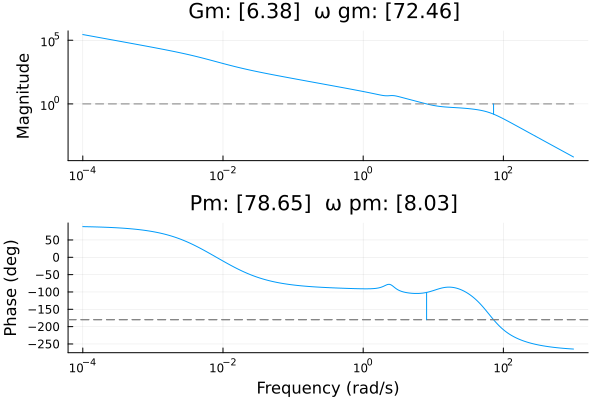

In [25]:
#roll rate compensator PID
k_p_p = 0.6
k_i_p = 8
k_d_p = 0.04
τ_d_p = 0.04

pcmp_tf = k_p_p + k_i_p * tf(1, [1,0]) + k_d_p * tf([1, 0], [τ_d_p, 1])

#input to the pitch rate compensator is pitch rate error, output is
#elevator_cmd, which feeds into e2q
pcmp = named_ss(ss(pcmp_tf), :pcmp; u = :p_err, y = :aileron_cmd)
pcmp_a2p_ol = series(pcmp, a2p_ol)

#steady-state error for a unit step input, now zero
ε_pcmp_a2p_cl = 1/(1+tf(pcmp_a2p_ol))
ε_pcmp_a2p_cl(0) |> display

marginplot(pcmp_a2p_ol)

StepInfo:
Initial value:     0.000
Final value:       0.998
Step size:         0.998
Peak:              1.037
Peak time:         0.452 s
Overshoot:          3.88 %
Undershoot:         0.00 %
Settling time:     1.129 s
Rise time:         0.213 s


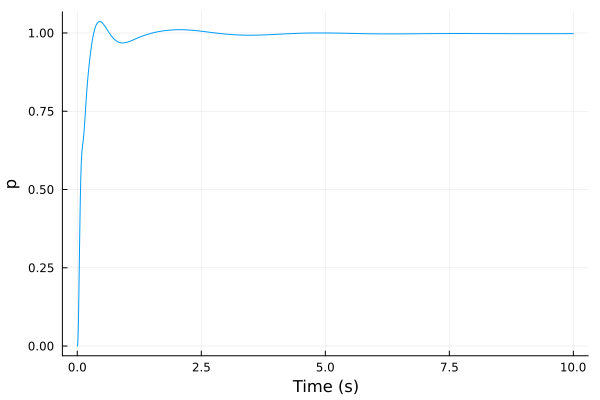

In [26]:
pcmp_a2p_cl = feedback(pcmp_a2p_ol)
pcmp_a2p_cl_step = step(pcmp_a2p_cl, 10)

# poles(minreal(pcmp_a2p_cl, 1e-3)) |> display
stepinfo(pcmp_a2p_cl_step) |> display
pcmp_a2p_cl_step |> plot

In [27]:
psum = sumblock("p_err = p_dmd - p")
p_rud_MIMO = connect([psum, pcmp, ail_rud_MIMO], [:p_err=>:p_err, :p=>:p, :aileron_cmd=>:aileron_cmd], w1 = [:p_dmd, :rudder_cmd], z1 = y_lat_labels)

#check we get the same response as with the SISO closed loop
pdmd2p = p_rud_MIMO[:p, :p_dmd]
step(pdmd2p, 10) |> plot

#ail_p_MIMO is our new plant baseline: lateral dynamics with embedded roll rate
#control and p_dmd and rudder_cmd as inputs
p_rud_MIMO

NamedStateSpace{Continuous, Float64}
A = 
     0.0                  8.0                 0.0                     0.0                    0.0                     0.0                     0.0                     0.0                     0.0                   0.0                   0.0                   0.0
     0.0                -25.0                -4.0                     0.0                    0.0                     0.0                     0.0                     0.0                     0.0                   0.0                   0.0                   0.0
     0.0                  0.0                -7.195356126404156       1.9471581362825012    -1.7298801952392306e-5  -3.6396096869673045e-7   0.010119997684410811   -0.3027366272975591      0.0                  10.77601636262896      0.0                  -0.9238190445839501
     0.0                  0.0                -0.23526358511300827    -0.9875929274401682     7.682200781289339e-6   -1.9838120371984402e-6   0.0003273602462281331   0

## 2. Sideslip Control

The starting plant is the lateral dynamics augmented with embedded roll rate control.

In [28]:
r2β = p_rud_MIMO[:β, :rudder_cmd]
zpk(r2β) |> display
poles(r2β) |> display

#we see that the unstable pole is still there, and its effect and
#controllability are greatly diluted by a near-cancellation. we will cancel it
#to design the compensator, and then check back in the complete closed loop MIMO
#system
r2β = minreal(r2β, 1e-2)
poles(r2β) |> display

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                           (1.0s^2 + 55.708759161759716s + 2943.846661859742)(1.0s^2 + 73.68436394113857s + 1614.2938415760998)(1.0s^2 + 9.299474100376512s + 57.65870591665316)(1.0s + 0.1521801614934829)(1.0s - 0.006817755414838206)(1.0s + 1.50626457477601e-6)
-140.44257984306347-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                   (1.0s + 48.05229742226742)(1.0s^2 + 75.39822368615503s + 3947.8417604357433)(1.0s^2 + 50.61170826916377s + 3187.3504239199974)(1.0s^2 + 9.04481093214527s + 55.760429572585586)(1.0s^2 + 1.2410506401640857s + 5.3167102588424715)(1.0s + 0.15174068956442932)(1.0s + 1.5062770764811

12-element Vector{ComplexF64}:
    -25.305854134581885 + 50.467456548148554im
    -25.305854134581885 - 50.467456548148554im
     -48.05229742226742 + 0.0im
     -4.522405466072635 + 5.942076941021711im
     -4.522405466072635 - 5.942076941021711im
    -0.6205253200820429 + 2.2207337944876575im
    -0.6205253200820429 - 2.2207337944876575im
   -0.15174068956442932 + 0.0im
   0.006685708501485966 + 0.0im
 -1.5062770764811858e-6 + 0.0im
     -37.69911184307752 + 50.26548245743669im
     -37.69911184307752 - 50.26548245743669im

10-element Vector{ComplexF64}:
  -37.699111843077524 + 50.26548245743669im
  -37.699111843077524 - 50.26548245743669im
  -25.305854137875503 + 50.46745654972282im
  -25.305854137875503 - 50.46745654972282im
   -48.05229741067138 + 0.0im
   -4.522413057433638 + 5.942105899593519im
   -4.522413057433638 - 5.942105899593519im
  -0.6205017110413352 + 2.220719899912663im
  -0.6205017110413352 - 2.220719899912663im
 -0.15180851030343798 + 0.0im

10-element Vector{ComplexF64}:
   -37.69733164045923 + 50.25274488589965im
   -37.69733164045923 - 50.25274488589965im
  -25.298859107244915 + 50.46805001072332im
  -25.298859107244915 - 50.46805001072332im
   -48.05986359764827 + 0.0im
   -4.522709368439974 + 5.938989559574378im
   -4.522709368439974 - 5.938989559574378im
  -0.6251743499864604 + 2.464342886622149im
  -0.6251743499864604 - 2.464342886622149im
 -0.15185488992138152 + 0.0im

ε_ir2β_cl(0) = [0.8230154130837665;;]


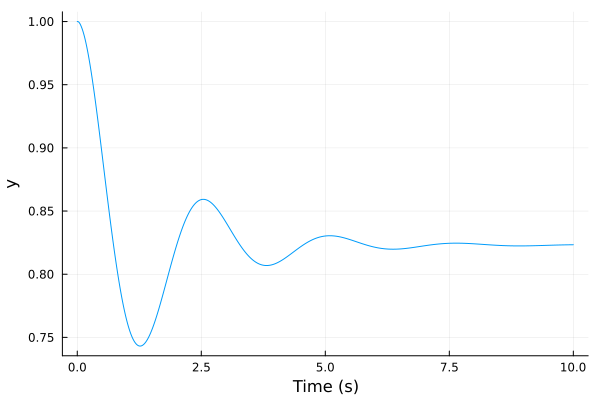

In [29]:
#the DC gain is negative. this makes sense, given that we have: act.rudder↑ ->
#aero.r↓ -> yaw↑ -> β↓. therefore, the first thing we need in the forward path
#for tracking a β command is a sign inversion in the rudder command right before
#the plant. it will take an inverted rudder_cmd from the compensator and output
#a rudder_cmd with the correct sign
rudder_inv = named_ss(ss(-1), u=:rudder_cmd_inv, y=:rudder_cmd)
ir2β = series(rudder_inv, r2β)

#output error transfer function for a unit feedback closed loop
ɛ_ir2β_cl = 1/(1+tf(ir2β))
ɛ_ir2β_cl |> poles |> display
@show ɛ_ir2β_cl(0)
step(ɛ_ir2β_cl, 10) |> plot

#of course, the response is unsatisfactory, but we at least see that the sign is
#now right: the error is reduced from its initial value of 1

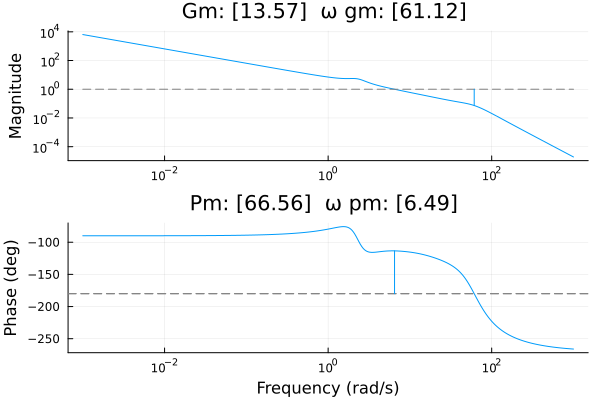

In [30]:
#from now on we move the sign inversion to the compensator and work with the
#non-inverted plant
k_p_β = 12
k_i_β = 30
k_d_β = 5
τ_d_β = 0.04
βcmp_tf = series(k_p_β + k_i_β * tf(1, [1,0]) + k_d_β * tf([1, 0], [τ_d_β, 1]), tf(-1))

βcmp = named_ss(ss(βcmp_tf), :βcmp; u = :β_err, y = :rudder_cmd)

βcmp_r2β = series(βcmp, r2β)

# ε_βcmp_r2β_cl = 1/(1+tf(βcmp_r2β))
# poles(ε_βcmp_r2β_cl) |> display #all stable
# @show ε_βcmp_r2β_cl(0)

marginplot(βcmp_r2β)

StepInfo:
Initial value:     0.000
Final value:       1.000
Step size:         1.000
Peak:              1.068
Peak time:         0.486 s
Overshoot:          6.78 %
Undershoot:         0.00 %
Settling time:     1.875 s
Rise time:         0.213 s


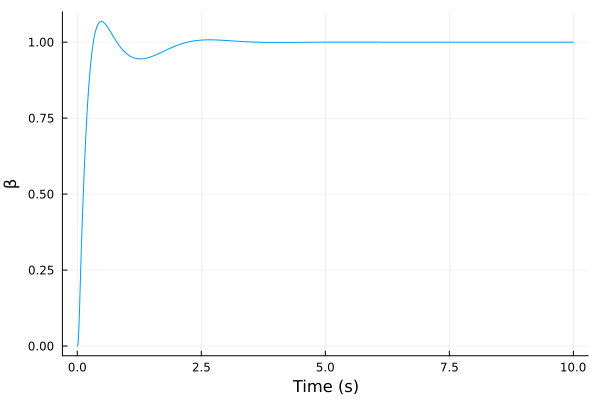

In [31]:
βcmp_r2β_cl = feedback(βcmp_r2β)
βcmp_r2β_cl_step = step(βcmp_r2β_cl, 10)

# poles(minreal(θcmp_qdmd2θ_cl, 1e-3)) |> display
stepinfo(βcmp_r2β_cl_step) |> display
βcmp_r2β_cl_step |> plot

In [32]:
βsum = sumblock("β_err = β_dmd - β")
p_β_MIMO = connect([βsum, βcmp, p_rud_MIMO], [:β_err=>:β_err, :β=>:β, :rudder_cmd=>:rudder_cmd], w1 = [:p_dmd, :β_dmd], z1 = y_lat_labels)

#check we get the same response as with the SISO closed loop
βdmd2β = p_β_MIMO[:β, :β_dmd]
step(βdmd2β, 10) |> plot

#we see that the unstable spiral pole is (all but) naturally cancelled
zpk(βdmd2β) |> display

#p_β_MIMO is our new plant baseline: lateral dynamics with embedded roll rate
#and sideslip control and p_dmd and β_dmd as inputs
p_β_MIMO

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                         (1.0s^2 + 55.7087591617597s + 2943.846661859732)(1.0s^2 + 73.68436394113877s + 1614.2938415761075)(1.0s^2 + 9.2994741003765s + 57.658705916653076)(1.0s^2 + 2.4087591240876183s + 5.474452554744543)(1.0s + 0.15218016149348343)(1.0s - 0.0068177554148363935)(1.0s + 1.5062645748219535e-6)
19240.633438499695---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  (1.0s + 50.0730525049105)(1.0s^2 + 73.50465996280269s + 3703.3380941162786)(1.0s^2 + 48.42190125944833s + 3177.9576085705767)(1.0s + 19.62738714669162)(1.0s + 6.024659108262944)(1.

NamedStateSpace{Continuous, Float64}
A = 
      0.0                  4.0                0.0                  0.0                 0.0                     0.0                    0.0                     0.0                     0.0                        0.0                     0.0                   0.0                   0.0                   0.0
      0.0                -25.0                0.0                  0.0                 0.0                     0.0                    0.0                     0.0                     0.0                       -1.2799999999999998      0.0                   0.0                   0.0                   0.0
      0.0                  0.0                0.0                  8.0                 0.0                     0.0                    0.0                     0.0                     0.0                        0.0                     0.0                   0.0                   0.0                   0.0
      0.0                  0.0                0.0

## 3. Bank Angle

We start from the plant with embedded roll rate and sideslip control.

In [33]:
p2φ = p_β_MIMO[:φ, :p_dmd]

NamedStateSpace{Continuous, Float64}
A = 
      0.0                  4.0                0.0                  0.0                 0.0                     0.0                    0.0                     0.0                     0.0                        0.0                     0.0                   0.0                   0.0                   0.0
      0.0                -25.0                0.0                  0.0                 0.0                     0.0                    0.0                     0.0                     0.0                       -1.2799999999999998      0.0                   0.0                   0.0                   0.0
      0.0                  0.0                0.0                  8.0                 0.0                     0.0                    0.0                     0.0                     0.0                        0.0                     0.0                   0.0                   0.0                   0.0
      0.0                  0.0                0.0

14-element Vector{ComplexF64}:
     -36.75657821586033 + 48.504157456651576im
     -36.75657821586033 - 48.504157456651576im
     -24.21861895703437 + 50.712670945711956im
     -24.21861895703437 - 50.712670945711956im
     -49.69036467252928 + 0.0im
     -19.65760133108758 + 0.0im
     -4.109241324049469 + 6.084258786383406im
     -4.109241324049469 - 6.084258786383406im
     -5.918759202567532 + 0.0im
    -1.4080912336775695 + 2.293513578855943im
    -1.4080912336775695 - 2.293513578855943im
    -1.0891699367192789 + 0.0im
   -0.15219265264915294 + 0.0im
 -1.8043278017199553e-7 + 0.0im

ε_p2φ_cl(0) = [-0.057116074818564164;;]


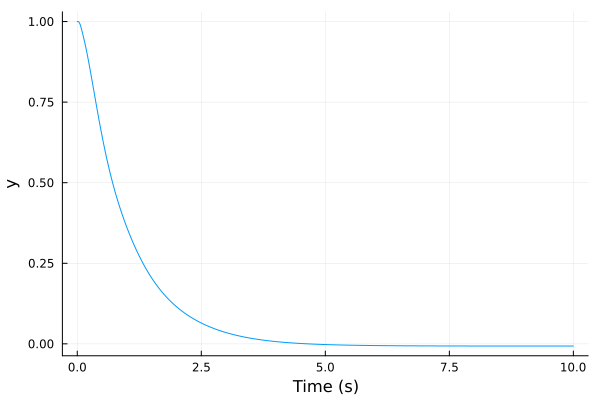

In [34]:
ɛ_p2φ_cl = 1/(1+tf(p2φ))
ɛ_p2φ_cl |> poles |> display
#all closed loop poles are stable
@show ɛ_p2φ_cl(0)
step(ɛ_p2φ_cl, 10) |> plot

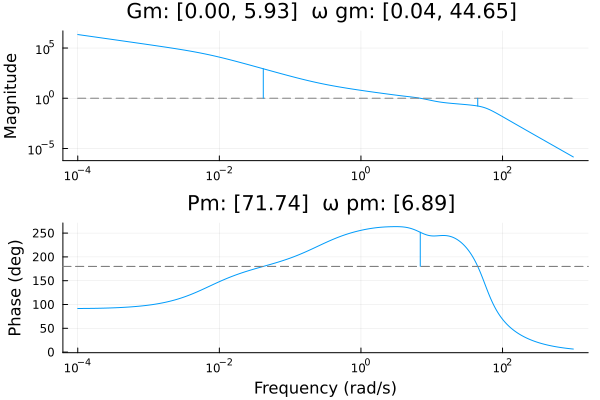

In [35]:
k_p_φ = 6
k_i_φ = 1.5
k_d_φ = 0.6
τ_d_φ = 0.04
φcmp_tf = k_p_φ + k_i_φ * tf(1, [1,0]) + k_d_φ * tf([1, 0], [τ_d_φ, 1])

φcmp = named_ss(ss(φcmp_tf), :φcmp; u = :φ_err, y = :p_dmd)
φcmp_p2φ = series(φcmp, p2φ)
ε_φcmp_p2φ = 1/(1+tf(φcmp_p2φ))

# setPlotScale("dB")
marginplot(φcmp_p2φ)
# nyquistplot(c_a2p)

StepInfo:
Initial value:     0.000
Final value:       1.004
Step size:         1.004
Peak:              1.037
Peak time:         1.204 s
Overshoot:          3.29 %
Undershoot:         0.00 %
Settling time:     2.972 s
Rise time:         0.238 s


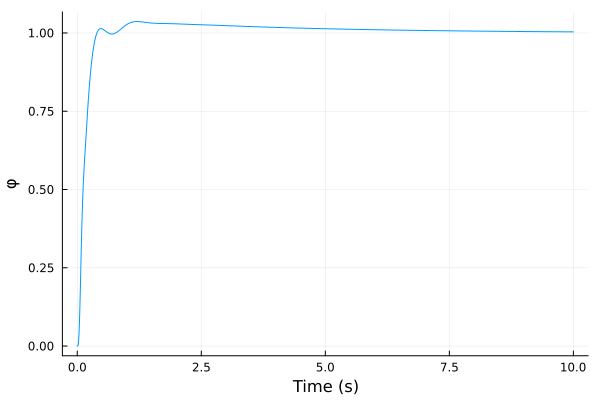

In [36]:
φcmp_p2φ_cl = feedback(φcmp_p2φ)
# φcmp_p2φ_cl |> poles |> display
φcmp_p2φ_cl_step = step(φcmp_p2φ_cl, 10)

# poles(minreal(θcmp_qdmd2θ_cl, 1e-3)) |> display
stepinfo(φcmp_p2φ_cl_step) |> display
φcmp_p2φ_cl_step |> plot


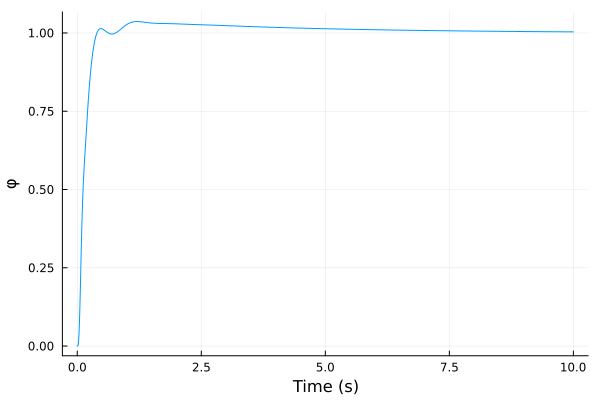

In [37]:
φsum = sumblock("φ_err = φ_dmd - φ")
φ_β_MIMO = connect([φsum, φcmp, p_β_MIMO], [:φ_err=>:φ_err, :φ=>:φ, :p_dmd=>:p_dmd], w1 = [:φ_dmd, :β_dmd], z1 = y_lat_labels)

#check we get the same response as with the SISO closed loop
φdmd2φ = φ_β_MIMO[:φ, :φ_dmd]
step(φdmd2φ, 10) |> plot

## 3. Course Angle

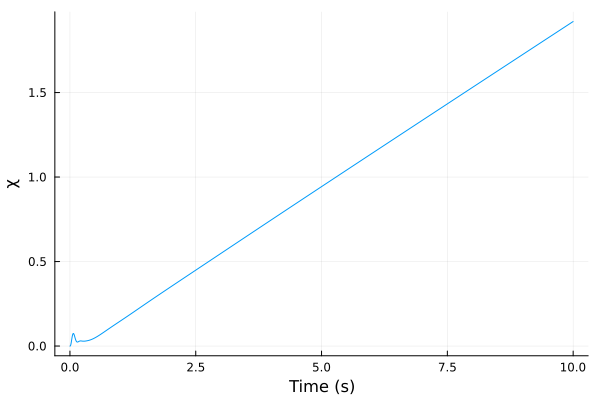

In [38]:
φ2χ = φ_β_MIMO[:χ, :φ_dmd]
step(φ2χ,10) |> plot